# Setup

In [5]:
!pip install wandb

In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np 
import pandas as pd 
import io
import os
import pickle
import wandb
from sklearn.model_selection import train_test_split
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
from functools import partial

print("Directory:", os.getcwd())
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Directory: /kaggle/working
/kaggle/input/cifar100/meta
/kaggle/input/cifar100/file.txt
/kaggle/input/cifar100/test
/kaggle/input/cifar100/train


In [7]:
wandb.login()

run = wandb.init(project='CIFAR100')

wandb.config = {
    "epochs": 10,
    "batch_size": 32,
    "shuffle_buffer": 10000,
}

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kacper-masny2000. Use `wandb login --relogin` to force relogin


In [8]:
os.mkdir("logs")

# Data 

## Importing the data and creating a dataset

In [9]:
def unpickle(file, enc):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding=enc)
    return dict

In [10]:
file = unpickle('/kaggle/input/cifar100/meta', 'utf-8')
fine_label_names, coarse_label_names = file.values()
print("fine_label_names: ", fine_label_names, sep="\n")
print("coarse_label_names: ", coarse_label_names, sep="\n")

fine_label_names: 
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'wha

In [11]:
data_pre_path = '/kaggle/input/cifar100/' # change this path
# File paths
data_train_path = data_pre_path + 'train'
data_test_path = data_pre_path + 'test'
# Read dictionary
data_train_dict = unpickle(data_train_path, 'bytes')
data_test_dict = unpickle(data_test_path, 'bytes')

# Get data (change the coarse_labels if you want to use the 100 classes)
data_train = data_train_dict[b'data']
label_train = np.array(data_train_dict[b'fine_labels'])
data_test = data_test_dict[b'data']
label_test = np.array(data_test_dict[b'fine_labels'])

print(data_train.shape, label_train.shape)

(50000, 3072) (50000,)


In [12]:
# data_train = data_train.reshape((50000, 32, 32, 3))
# data_test = data_test.reshape((10000, 32, 32, 3))
# label_train = label_train.reshape((50000, 1))
# label_test = label_test.reshape((10000, 1))

data_train = data_train.reshape((50000, 3, 32, 32))
data_test = data_test.reshape((10000, 3, 32, 32))
data_train = data_train.transpose(0, 2, 3, 1)
data_test = data_test.transpose(0, 2, 3, 1)
label_train = label_train.reshape((50000, 1))
label_test = label_test.reshape((10000, 1))

X_train, X_val, y_train, y_val = train_test_split(data_train, label_train, stratify=label_train, test_size=0.2)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((data_test, label_test))

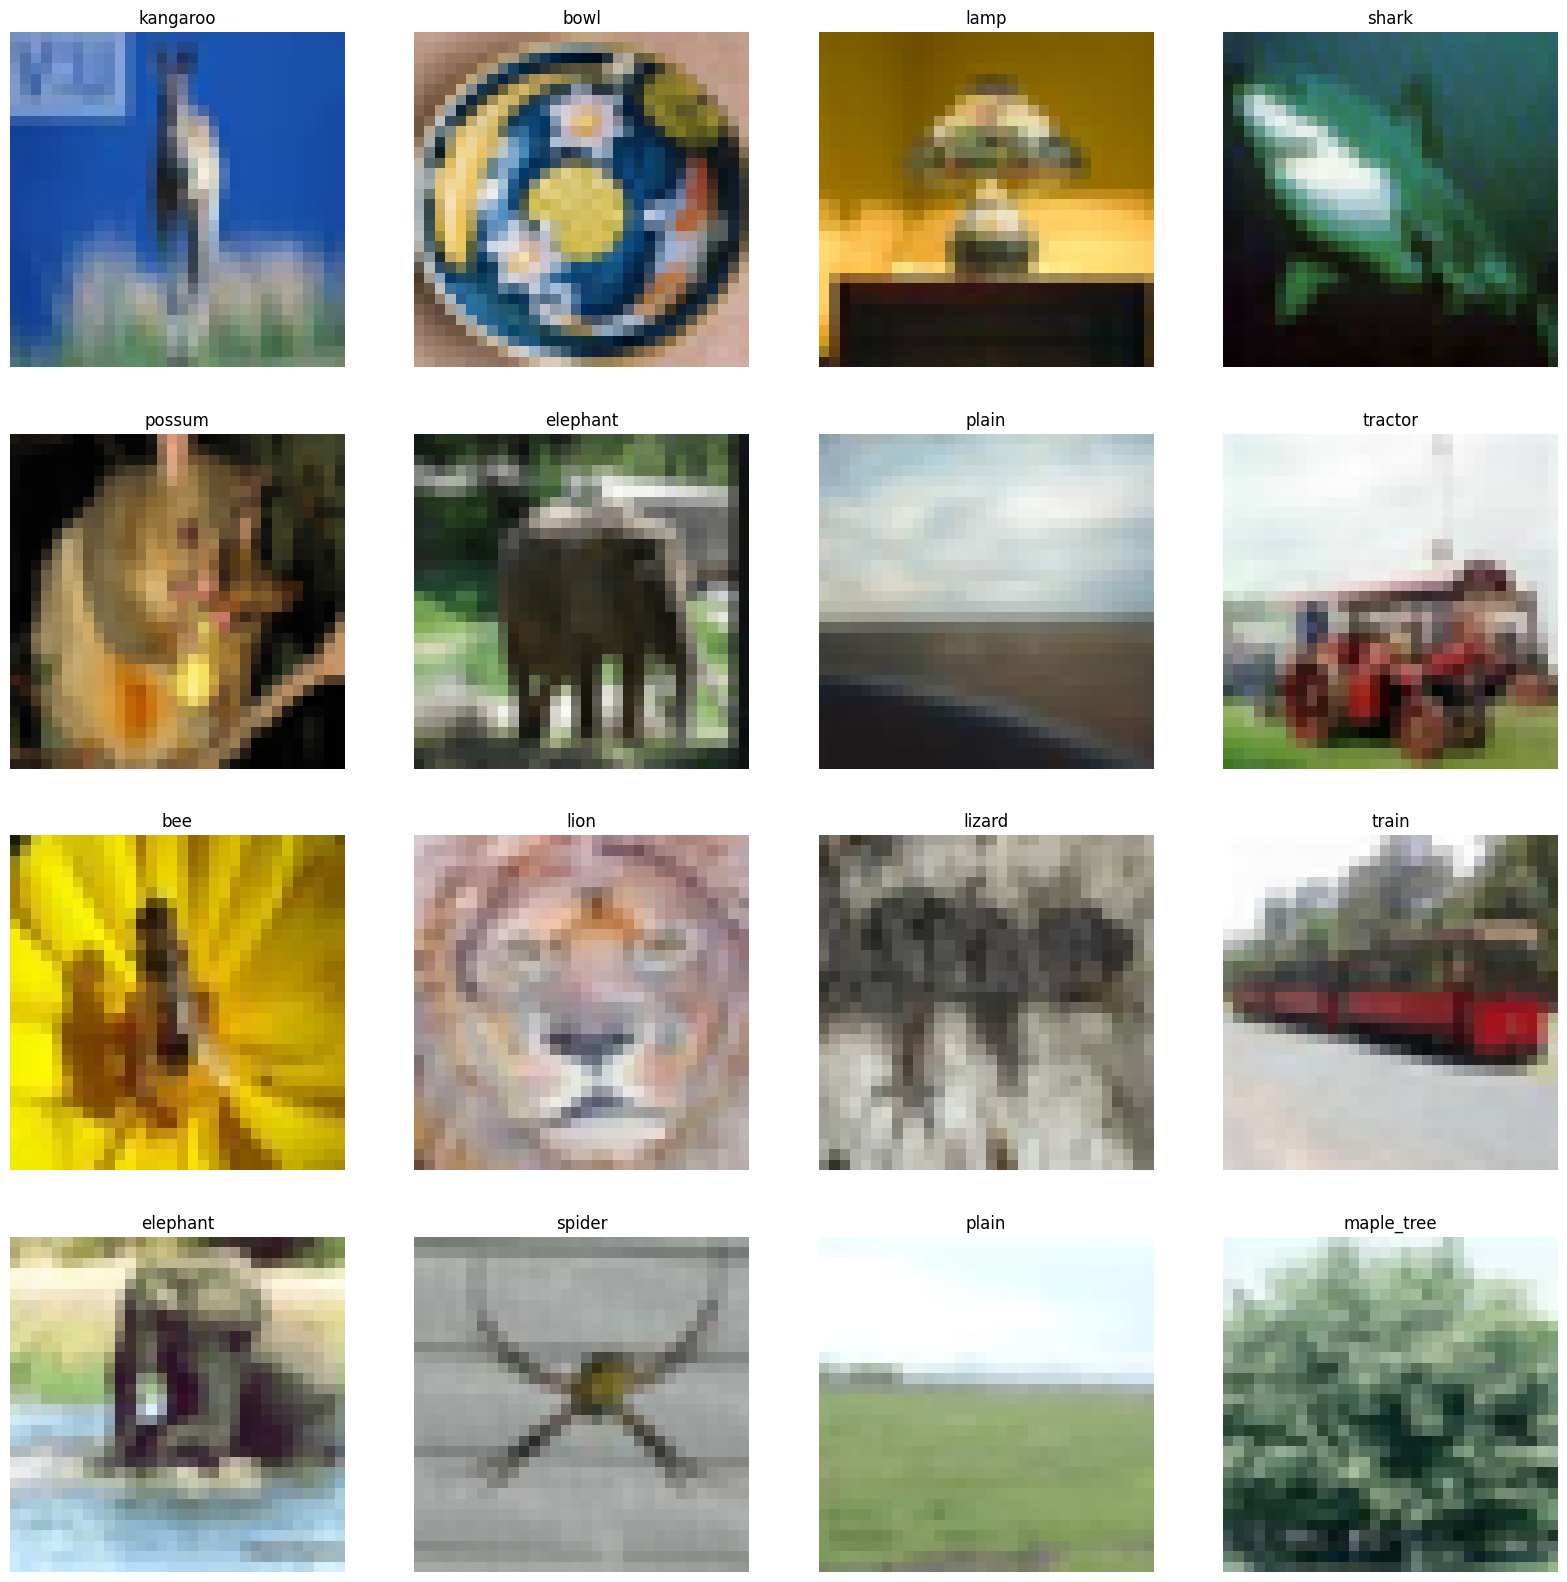

In [13]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
for i, pic in enumerate(train_ds.take(16)):
    x, y = pic
    r = i // 4 
    c = i % 4
    axs[r, c].imshow(x.numpy())
    axs[r,c].set_title(fine_label_names[y.numpy()[0]])
    axs[r, c].axis('off')

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.batch(wandb.config['batch_size']).cache().shuffle(wandb.config['shuffle_buffer']).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.batch(wandb.config['batch_size']).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.batch(wandb.config['batch_size']).cache().prefetch(buffer_size=AUTOTUNE)

## Data Augmentation

In [17]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",input_shape=(32, 32,3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.Rescaling(1./255)
  ]
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Model

### Model 1

A simple sequential model with conv layers from the book Hands on ML

In [19]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, 
                        padding='same', activation="relu", kernel_initializer="he_normal")

def get_model():
    model = tf.keras.Sequential([
        data_augmentation,
        DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=128),
        DefaultConv2D(filters=128),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=256),
        DefaultConv2D(filters=256),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=128, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=64, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=10, activation="softmax")
    ])
    return model

# Training

### Device setup

In [20]:
gpus = tf.config.list_physical_devices(
    device_type='GPU'
)
if len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy()

### Callbacks

In [22]:
os.mkdir("models")

In [24]:
callbacks = [
        WandbMetricsLogger()
    ]

# 

### Training

In [29]:
with strategy.scope():
    model = get_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

In [30]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=10
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 25ms/step - accuracy: 0.0194 - loss: nan - val_accuracy: 0.0108 - val_loss: nan
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.0205 - loss: nan - val_accuracy: 0.0108 - val_loss: nan
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.0212 - loss: nan - val_accuracy: 0.0108 - val_loss: nan
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.0194 - loss: nan - val_accuracy: 0.0108 - val_loss: nan
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.0193 - loss: nan - val_accuracy: 0.0108 - val_loss: nan
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.0220 - loss: nan - val_accuracy: 0.0108 - val_loss: nan
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.0199 - loss: nan - val_accuracy: 0.0108 - val_loss: nan
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.0185 - loss: nan - val_accuracy: 0.0108 - val_lo

# Evaluation

In [32]:
score = model.evaluate(test_ds)

print(score)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0218 - loss: nan
[nan, 0.009200000204145908]
